## Compressing Data via Dimensionality Reduction

An alternative approach to feature selection for dimensionality reduction is feature extraction. In this notebook, I'll implement dimensionality reduction techniques through numpy and scikit-learn.

- Principal component analysis (PCA) for unsupervised data compression
- Linear Discriminant Analysis (LDA) as a supervised dimensionality reduction technique for maximizing class separability

### Implement PCA step by step via Numpy

1. Standardize the d-dimensional dataset.
2. Construct the covariance matrix.
3. Decompose the covariance matrix into its eigenvectors and eigenvalues.
4. Select k eigenvectors that correspond to the k largest eigenvalues, where k is the dimensionality of the new feature subspace (k<=d).
5. Construct a projection matrix W from the "top" k eigenvectors.
6. Transform the d-dimensional input dataset X using the projectionmatrix W to obtain the new k-dimensional feature subspace.

In [1]:
# load wine dataset

import pandas as pd
from sklearn.model_selection import train_test_split

df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                      'machine-learning-databases/wine/wine.data',
                      header=None)

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

1) Standardize the d-dimensional dataset

In [3]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

2) Construct the covariance matrix.

In [9]:
import numpy as np

cov_mat = np.cov(X_train_std.T)


3) Decompose the covariance matrix into its eigenvectors and eigenvalues.

In [13]:
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

print('\nEigenvalues \n%s' % eigen_vals)


Eigenvalues 
[ 4.8923083   2.46635032  1.42809973  1.01233462  0.84906459  0.60181514
  0.52251546  0.08414846  0.33051429  0.29595018  0.16831254  0.21432212
  0.2399553 ]


4) Sort eigenvalues and select k eigenvectors that correspond to the k largest eigenvalues, where k is the dimensionality of the new feature subspace (k<=d)

In [14]:
# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eigen_pairs.sort(key=lambda k: k[0], reverse=True)


5) Construct a projection matrix W from the "top" k eigenvectors.

In [15]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis],
               eigen_pairs[1][1][:, np.newaxis]))
print('Matrix W:\n', w)

Matrix W:
 [[ 0.14669811  0.50417079]
 [-0.24224554  0.24216889]
 [-0.02993442  0.28698484]
 [-0.25519002 -0.06468718]
 [ 0.12079772  0.22995385]
 [ 0.38934455  0.09363991]
 [ 0.42326486  0.01088622]
 [-0.30634956  0.01870216]
 [ 0.30572219  0.03040352]
 [-0.09869191  0.54527081]
 [ 0.30032535 -0.27924322]
 [ 0.36821154 -0.174365  ]
 [ 0.29259713  0.36315461]]


6) Transform the d-dimensional input dataset X using the projection matrix W to obtain the new k-dimensional feature subspace

In [16]:
X_train_pca = X_train_std.dot(w)

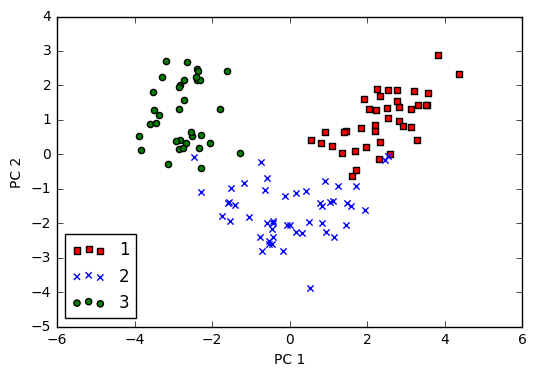

In [17]:
import matplotlib.pyplot as plt
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train == l, 0], 
                X_train_pca[y_train == l, 1], 
                c=c, label=l, marker=m)

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.show()

### Implement PCA via scikit-learn

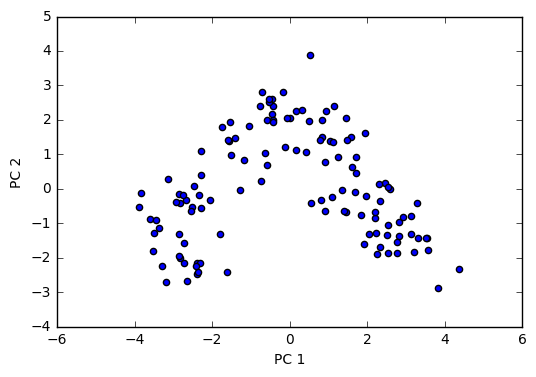

In [18]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)


plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1])
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

If we are interested in the explained variance ratios of the different principal
components, we can simply initialize the PCA class with the n_components parameter
set to None, so all principal components are kept and the explained variance ratio can
then be accessed via the 'explained_variance_ratio_':

In [19]:
pca = PCA(n_components=None)
X_train_pca = pca.fit_transform(X_train_std)
pca.explained_variance_ratio_

array([ 0.37329648,  0.18818926,  0.10896791,  0.07724389,  0.06478595,
        0.04592014,  0.03986936,  0.02521914,  0.02258181,  0.01830924,
        0.01635336,  0.01284271,  0.00642076])

### Implement LDA step by step via Numpy

1. Standardize the d-dimensional dataset (d is the number of features).
2. For each class, compute the d-dimensional mean vector.
3. Construct the between-class scatter matrix S_B and the within-class scatter matrix.
4. Compute the eigenvectors and corresponding eigenvalues of the matrix $S_W^{-1}S_B$.
5. Choose the k eigenvectors that correspond to the k largest eigenvalues to construct a d×k-dimensional transformation matrix W; the eigenvectors are the columns of this matrix.
6. Project the samples onto the new feature subspace using the transformation matrix W

2) Calculate the mean vectors for each class:

In [20]:
np.set_printoptions(precision=4)

mean_vecs = []
for label in range(1, 4):
    mean_vecs.append(np.mean(X_train_std[y_train == label], axis=0))


3a) Compute the within-class scatter matrix S_W (same as computing the covariance matrix):

In [21]:
d = 13  # number of features
S_W = np.zeros((d, d))
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.cov(X_train_std[y_train == label].T)
    S_W += class_scatter

3b) Compute the between-class scatter matrix:

In [22]:
mean_overall = np.mean(X_train_std, axis=0)
d = 13  # number of features
S_B = np.zeros((d, d))
for i, mean_vec in enumerate(mean_vecs):
    n = X_train[y_train == i + 1, :].shape[0]
    mean_vec = mean_vec.reshape(d, 1)  # make column vector
    mean_overall = mean_overall.reshape(d, 1)  # make column vector
    S_B += n * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)

4) Solve the generalized eigenvalue problem for the matrix $S_W^{-1}S_B$:

In [24]:
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i])
               for i in range(len(eigen_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues

print('Eigenvalues in decreasing order:\n')
for eigen_val in eigen_pairs:
    print(eigen_val[0])

Eigenvalues in decreasing order:

452.721581245
156.43636122
6.29861558094e-14
6.0882566973e-14
5.68434188608e-14
5.00970127324e-14
1.62888285062e-14
1.62888285062e-14
1.27604136115e-14
1.21605269177e-14
7.47931337016e-15
7.47931337016e-15
9.15717517221e-16


We only have two nonzero eigenvalues (rank 2). The first two linear discriminants capture
about 100 percent of the useful information in the Wine training dataset.

5) Choose the k eigenvectors that correspond to the k largest eigenvalues to construct a d × k-dimensional transformation matrix W

In [25]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis].real,
              eigen_pairs[1][1][:, np.newaxis].real))
print('Matrix W:\n', w)

Matrix W:
 [[-0.0662 -0.3797]
 [ 0.0386 -0.2206]
 [-0.0217 -0.3816]
 [ 0.184   0.3018]
 [-0.0034  0.0141]
 [ 0.2326  0.0234]
 [-0.7747  0.1869]
 [-0.0811  0.0696]
 [ 0.0875  0.1796]
 [ 0.185  -0.284 ]
 [-0.066   0.2349]
 [-0.3805  0.073 ]
 [-0.3285 -0.5971]]


6) Project the samples onto the new feature subspace using the transformation matrix W

In [26]:
X_train_lda = X_train_std.dot(w)

### Implement LDA via scikit-learn

In [29]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train_std, y_train)
X_test_lda = lda.transform(X_test_std)